# Ethereum transactions analysis

## Read the pandas dataframe parquet files

In [1]:
import os
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PATH = '../data/'

In [3]:
pd.set_option('display.max_columns', 100, 'display.max_rows', 100, 'display.max_colwidth', 100)
# pd.set_option('display.float_format', lambda x: '%.f' % x)

In [4]:
file_dir = os.listdir(PATH)
file_list = [os.path.join(PATH, file) for file in file_dir if file.startswith('df_')]

In [5]:
df_raw = pd.concat([pd.read_parquet(file) for file in file_list])

### Convert `type` to categorical data type
Seems to have reverted to 'int64' after reading from parquet into dataframe.

In [9]:
df_raw['type'] = df_raw['type'].astype('category')

### Keeping the dataset to 1 to 7 July 2022

In [10]:
df = df_raw.query('block_timestamp.between("2022-07-01", "2022-07-08", inclusive="both")')

#### Data fields
- `hash` - Hash of the transaction
- `blockHash` - Hash of the block
- `blockNumber` - Block number
- `from` - Address of the sender
- `gas` - Gas provided by the sender
- `gasPrice` - Gas price provided by the sender in Wei
- `input` - The data sent along with the transaction. Commonly used as part of contract interaction or as a message sent to the recipient. See 
- `nonce` - The number of transactions made by the sender prior to this one
- `r` - The Elliptic Curve Digital Signature Algorithm (ECDSA) signature r. The standardised R field of the signature. See: https://openethereum.github.io/JSONRPC
- `s` - The Elliptic Curve Digital Signature Algorithm (ECDSA) signature s
- `to` - Address of the receiver
- `transactionIndex` - Integer of the transactions index position in the block
- `type` - Overtime, Ethereum Improvement Proposals (EIPs) have changed what a valid transaction looks like, whilst maintaining a high level of backwards compatibility with other transaction types. Today, the main types of transactions are legacy transactions and typed transactions (i.e. Type 1, Type 2).  
See https://mycelium.xyz/research/the-journey-of-an-ethereum-transaction/.  
Also see https://docs.dune.com/data-tables/data-tables/raw-data/ethereum-data#ethereum.transactions. 
   - 0: 'legacy' 
   - 1: 'accessList/Type 1' 
   - 2: 'DynamicFee/Type 2'    
- `v` - The Elliptic Curve Digital Signature Algorithm (ECDSA) recovery id. The standardised V field of the signature. See: https://openethereum.github.io/JSONRPC
- `value` - The amount of ether transferred in Wei.
- `accessList` - Contains addresses and storage keys that will be accessed. These are fields from legacy transactions, EIP-2930. See: https://openethereum.github.io/JSONRPC
- `chainId` - Value used in replay-protected transaction signing as introduced by EIP-155
- `maxFeePerGas` - The maximum fee per gas the transaction sender is willing to pay total (introduced by EIP1559). For detailed explanation, refer to https://docs.alchemy.com/alchemy/guides/eip-1559/maxpriorityfeepergas-vs-maxfeepergas
- `maxPriorityFeePerGas` - The maximum fee per gas the transaction sender is willing to pay total (introduced by EIP1559) Refer to https://docs.alchemy.com/alchemy/guides/eip-1559/maxpriorityfeepergas-vs-maxfeepergas
- `block_timestamp` - Timestamp of the block

References:  
https://docs.dune.com/data-tables/data-tables/raw-data/ethereum-data#ethereum.transactions  
The "bigquery-public-data.crypto_ethereum.transactions" column description  
https://ethereum.org/en/developers/docs/apis/json-rpc/  
https://docs.alchemy.com/alchemy/apis/ethereum/eth-gettransactionbyhash  

### We have the following entities in our domain:
- Blocks
- Transaction
- Value and Fees
- Account

The process/relationship:
- A block contains multiple transactions
- A transaction is a request for computation on the Ethereum Virtual Machine (EVM) and it is a fulfilled transaction request and the associated change in the EVM.  
When a request is broadcast, other participants on the network verify, validate and carry out the computation.  
A transaction refers to an action initiated by an externally owned account, in other words, managed by a human not a contract (smart contract, ie. controlled by code).
A transaction requires a fee and must be mined to be valid.
- An account can be externally-owned or a contract (smart contract)

References:
https://ethereum.org/en/developers/docs/intro-to-ethereum/

### We have the following information about our entities:
- Blocks: `blockHash`, `blockNumber`, `block_timestamp`
- Transaction: `hash`, `from`, `to`, `transactionIndex`, `type`, `input`, `chainId`
- Value and Fees: `value`, `gas`, `gasPrice`, `maxFeePerGas`, `maxPriorityFeePerGas`
- Account: `nonce`

## Univariate analysis

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8212460 entries, 0 to 3011962
Data columns (total 16 columns):
 #   Column                Dtype         
---  ------                -----         
 0   hash                  object        
 1   blockHash             object        
 2   blockNumber           int64         
 3   chainId               float64       
 4   from                  object        
 5   gas                   int64         
 6   gasPrice              int64         
 7   input                 object        
 8   maxFeePerGas          float64       
 9   maxPriorityFeePerGas  float64       
 10  nonce                 int64         
 11  to                    object        
 12  transactionIndex      int64         
 13  type                  category      
 14  value                 float64       
 15  block_timestamp       datetime64[ns]
dtypes: category(1), datetime64[ns](1), float64(4), int64(5), object(5)
memory usage: 1010.3+ MB


In [17]:
df.head(3)

,hash,blockHash,blockNumber,chainId,from,gas,gasPrice,input,maxFeePerGas,maxPriorityFeePerGas,nonce,to,transactionIndex,type,value,block_timestamp
0,0x4ba4952586cd471bf7be6f5bce210a52fb1139e279994bbfe05353884b77f325,0xc21f383b86f543e0038ada2a3554bf2b7ced841fad4363871f1fd8400721aff9,15053949,1.0,0xea674fdde714fd979de3edf0f56aa9716b898ec8,250000,17082324542,0x,3.805209e+10,1.000000e+09,43640737,0x40329687913cf9d84e3132cb4d8d61130704599d,0,2,9.971602e+16,2022-07-01 02:36:35
1,0xd04e6bed821f4c616a400d5bb43a525dbad01fff53b2fb42c9a40d448df371c4,0xc21f383b86f543e0038ada2a3554bf2b7ced841fad4363871f1fd8400721aff9,15053949,1.0,0xea674fdde714fd979de3edf0f56aa9716b898ec8,250000,17082324542,0x,3.805209e+10,1.000000e+09,43640738,0xb55ec04cbda8d2d602f3108ddb66496a3cb1ee9b,1,2,9.962975e+16,2022-07-01 02:36:35
2,0xc1f95ac0a6f41e9a53713193e83af95694052181a2ec9b788ab00ab389412cb6,0xc21f383b86f543e0038ada2a3554bf2b7ced841fad4363871f1fd8400721aff9,15053949,1.0,0xea674fdde714fd979de3edf0f56aa9716b898ec8,250000,17082324542,0x,3.805209e+10,1.000000e+09,43640739,0xdd27415aa937d75f13bf5877f7cbf092e42612b3,2,2,1.734777e+16,2022-07-01 02:36:35


How many blocks are there in our dataset?

In [23]:
df['blockNumber'].nunique()

43706

How many transactions?

In [21]:
df.shape[0]

8212460

How many senders?

In [22]:
df['from'].nunique()

1782142

How many recipients?

In [24]:
df['to'].nunique()

1311994

In [37]:
pd.set_option('display.float_format', lambda x: '%.f' % x)

What is the minimum and maximum `gas`?

In [38]:
df['gas'].describe()

count    8212460
mean      163931
std       385066
min        21000
25%        31500
50%        90000
75%       207128
max     30029295
Name: gas, dtype: float64

In [ ]:
df.query('gas == 30029295')

,hash,blockHash,blockNumber,chainId,from,gas,gasPrice,input,maxFeePerGas,maxPriorityFeePerGas,nonce,to,transactionIndex,type,value,block_timestamp
642917,0xdd6d61a22ede7b658487fd45bb645f1dfecab607d48e2e1e50cf0915e3d18abf,0x35ffb57b42bb69b018f95c39b7b0e84bac7e91d8c854149d7192eb20912b854d,15078507,1,0x6d72dc1b254fb818a1382a05212466b83424e469,30029295,25375730731,0x8fe5d2e90000000000000000000000000000000000000000000000000000000000e611910000000000000000000000...,37015077777,7000000000,37,0x30f7bf69d92828441f5a6bfcf818df25deb2c4b4,0,2,0,2022-07-04 21:33:21


What is the minimum and maximum `gasPrice`?

In [27]:
df['gasPrice'].describe()

count    8.212460e+06
mean     3.015800e+10
std      1.227708e+11
min      3.717514e+09
25%      1.455000e+10
50%      2.138334e+10
75%      3.489424e+10
max      2.294510e+14
Name: gasPrice, dtype: float64

In [28]:
df['nonce'].describe()

count    8.212460e+06
mean     1.317989e+06
std      5.830671e+06
min      0.000000e+00
25%      1.500000e+01
50%      1.830000e+02
75%      1.693500e+04
max      4.377498e+07
Name: nonce, dtype: float64

In [29]:
df['transactionIndex'].describe()

count    8.212460e+06
mean     1.383877e+02
std      1.141302e+02
min      0.000000e+00
25%      5.000000e+01
50%      1.120000e+02
75%      2.020000e+02
max      1.307000e+03
Name: transactionIndex, dtype: float64

In [30]:
df['type'].value_counts(dropna=False)

2    6881664
0    1315335
1      15461
Name: type, dtype: int64

In [31]:
df['type'].value_counts(dropna=False, normalize=True)

2    0.837954
0    0.160163
1    0.001883
Name: type, dtype: float64

In [32]:
# pd.set_option('display.float_format', lambda x: '%.f' % x)

In [33]:
df['value'].describe()

count    8.212460e+06
mean     1.697553e+18
std      1.871322e+20
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      4.800000e+16
max      1.500000e+23
Name: value, dtype: float64

In [34]:
df['chainId'].value_counts(dropna=False, normalize=True)

1.0    0.839837
NaN    0.160163
Name: chainId, dtype: float64

In [44]:
# pd.set_option('display.float_format', lambda x: '%.f' % x)

In [35]:
df['maxFeePerGas'].describe()

count    6.881664e+06
mean     6.971994e+10
std      1.914036e+11
min      3.717514e+09
25%      2.200000e+10
50%      3.469551e+10
75%      6.196162e+10
max      2.294510e+14
Name: maxFeePerGas, dtype: float64

In [36]:
df['maxPriorityFeePerGas'].describe()

count    6.881664e+06
mean     5.248661e+09
std      1.149491e+11
min      0.000000e+00
25%      1.500000e+09
50%      2.000000e+09
75%      2.500000e+09
max      2.294510e+14
Name: maxPriorityFeePerGas, dtype: float64

## Overall figures
In this analysis, we will not look into:  
The `r`, `s` and `v` which are the ECDSA signatures.  
`accessList` which contains addresses and storage keys from legacy transactions. The field also needs to be flattened.  
All transactions are included regardless of status, ie. success or failed (no field to determine this in the dataset).
- How many blocks are there in our dataset?  
43,706
- How many transactions?  
8,212,460
- How many senders:  
1,782,142
- How many recipients:  
1,311,992
- What are the categories in `type`?  
84% of transactions are 2, 16% are 0 and 0.002% are 1
- What are the categories in `chainId`
84% are 1 and 16% are missing the `chainId`
- Which dates were these transactions executed?
2022-07-01 to 2022-07-07

## Key Findings on Overall Figures
- There are more senders than recipients. Why?
- The 84% of transactions has a `type` of 2 and 16% are 0. The 84% vs 16% split is the same as `chainId` split. What is the relationship? 
- An example of an outlier with `gas` = 30,029,295 was a failed transaction, see `hash` = '0xdd6d61a22ede7b658487fd45bb645f1dfecab607d48e2e1e50cf0915e3d18abf'. Note that the `value` is 0. Also confirmed in https://etherscan.io/tx/0xdd6d61a22ede7b658487fd45bb645f1dfecab607d48e2e1e50cf0915e3d18abf. Comments in etherscan says "WRONG_BLOCK_NUMBER" but another checking the Alchemy API with eth_getTransactionByHash confirmed it is correct block number. This transaction did not appear in Dune.

How many blocks per day?

In [12]:
df.resample('D', on='block_timestamp').agg(blocks=('blockNumber','nunique'))

,blocks
block_timestamp,
2022-07-01,6253
2022-07-02,6227
2022-07-03,6315
2022-07-04,6200
2022-07-05,6242
2022-07-06,6280
2022-07-07,6189


How many transactions per day?

In [48]:
df.resample('D', on='block_timestamp').size()

block_timestamp
2022-07-01    1178620
2022-07-02    1189382
2022-07-03    1157052
2022-07-04    1150609
2022-07-05    1181035
2022-07-06    1161432
2022-07-07    1194330
Freq: D, dtype: int64

Total value per day?

In [49]:
df.resample('D', on='block_timestamp').agg(total_value=('value','sum'))

,total_value
block_timestamp,
2022-07-01,2529957095970754663546880
2022-07-02,1242727481254419196018688
2022-07-03,802698618545780836794368
2022-07-04,1979039773764470716760064
2022-07-05,1838238726207302323404800
2022-07-06,1882904639433685247983616
2022-07-07,3665519196793809473110016


Year over year difference July 2021 vs July 2022

In [78]:
data = {'2021-07-01':1211710, '2021-07-02':1181574, '2021-07-03':1122543, '2021-07-04':1105343, '2021-07-05':1147895, '2021-07-06':1355421, '2021-07-07':1290979}
s_2021 = pd.Series(data)
s_2021.index = pd.to_datetime(s_2021.index)

In [75]:
s_2022 = df.resample('D', on='block_timestamp').size()

In [79]:
s_daily = pd.concat([s_2021,s_2022])

In [80]:
s_daily

2021-07-01    1211710
2021-07-02    1181574
2021-07-03    1122543
2021-07-04    1105343
2021-07-05    1147895
2021-07-06    1355421
2021-07-07    1290979
2022-07-01    1178620
2022-07-02    1189382
2022-07-03    1157052
2022-07-04    1150609
2022-07-05    1181035
2022-07-06    1161432
2022-07-07    1194330
dtype: int64

In [89]:
s_daily.diff(periods=7).iloc[7:]

2022-07-01    -33090.0
2022-07-02      7808.0
2022-07-03     34509.0
2022-07-04     45266.0
2022-07-05     33140.0
2022-07-06   -193989.0
2022-07-07    -96649.0
dtype: float64

<AxesSubplot:>

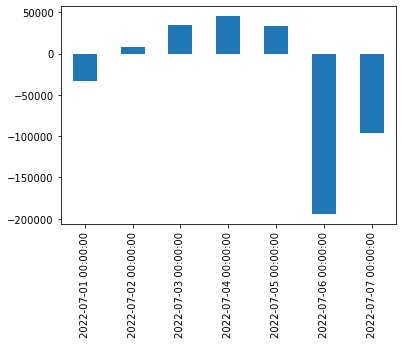

In [90]:
s_daily.diff(periods=7).iloc[7:].plot(kind='bar')

In [103]:
s_daily_pct = s_daily.pct_change(periods=7).iloc[7:]*100

<AxesSubplot:>

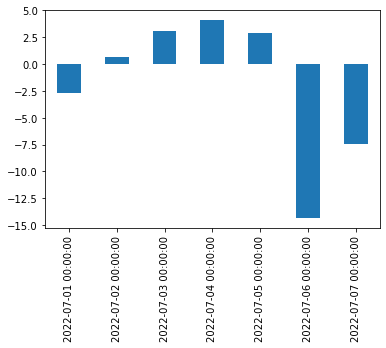

In [104]:
s_daily_pct.plot(kind='bar')

In [105]:
s_daily_pct

2022-07-01    -2.730851
2022-07-02     0.660813
2022-07-03     3.074181
2022-07-04     4.095199
2022-07-05     2.887024
2022-07-06   -14.312085
2022-07-07    -7.486489
dtype: float64

In [120]:
df['blockNumber'].min(), df['blockNumber'].max()

(15053226, 15098519)

In [154]:
block_txn = json.load(open('../data/raw/block_txn_counts.json'))

In [155]:
tmp_df = pd.DataFrame(block_txn)

In [156]:
tmp_df['block_timestamp'] = tmp_df['block_timestamp'].astype('datetime64[s]')

In [112]:
tmp_df['block_timestamp'].min(), tmp_df['block_timestamp'].max()

(Timestamp('2021-06-30 23:59:04'), Timestamp('2021-07-08 00:45:19'))

In [132]:
tmp_df['block_timestamp'].min(), tmp_df['block_timestamp'].max()

(Timestamp('2021-06-30 23:59:04'), Timestamp('2022-06-30 23:59:28'))

In [158]:
tmp_df['block_timestamp'].min(), tmp_df['block_timestamp'].max()

(Timestamp('2021-06-30 23:59:04'), Timestamp('2022-07-03 14:49:46'))

In [159]:
tmp_df

,block_number,block_transactions,block_timestamp
0,12738503,160,2021-06-30 23:59:04
1,12738504,164,2021-06-30 23:59:15
2,12738505,142,2021-06-30 23:59:22
3,12738506,126,2021-06-30 23:59:37
4,12738507,160,2021-06-30 23:59:44
...,...,...,...
62120,15070221,35,2022-07-03 14:49:26
62121,15070222,141,2022-07-03 14:49:31
62122,15070223,40,2022-07-03 14:49:38
62123,15070224,83,2022-07-03 14:49:43
